In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import statsmodels.api as sm
from scipy import stats
from scipy.stats import boxcox
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RepeatedKFold, cross_validate
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

2024-03-11 15:32:51.648686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


# Data Cleaning (KaggleMovies.csv)

df is going to have all of our data about each movies

In [5]:
# Read the dataset
df = pd.read_csv('Datasets/KaggleMovies.csv')
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.precision', 2)
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,927000.000000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.000000,46998772.000000,Warner Bros.,146.000000
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,65000.000000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.000000,58853106.000000,Columbia Pictures,104.000000
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,1200000.000000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.000000,538375067.000000,Lucasfilm,124.000000
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,221000.000000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.000000,83453539.000000,Paramount Pictures,88.000000
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,108000.000000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.000000,39846344.000000,Orion Pictures,98.000000


In [6]:
# Renaming columns
column_mapping = {
    'name' : 'Name',
    'rating' : 'Rating',
    'genre' : 'Genre',
    'year' : 'Year',
    'released' : 'Released',
    'score' : 'Score',
    'votes' : 'Votes',
    'director' : 'Director',
    'writer' : 'Writer',
    'star' : 'Star',
    'country' : 'Country',
    'budget' : 'Budget',
    'gross' : 'Gross Revenue',
    'company' : 'Company',
    'runtime' : 'Runtime'
}

df = df.rename(columns=column_mapping)

In [7]:
# Check for empty spaces
print(f"Shape: {df.shape}\n")
isna = df.isna().sum(axis=0)
isna

Shape: (7668, 15)



Name                0
Rating             77
Genre               0
Year                0
Released            2
Score               3
Votes               3
Director            0
Writer              3
Star                1
Country             3
Budget           2171
Gross Revenue     189
Company            17
Runtime             4
dtype: int64

In [8]:
# Remove rows with null values
df = df.dropna()
print(f"Shape: {df.shape}\n")
print(df.isna().sum(axis=0))

Shape: (5421, 15)

Name             0
Rating           0
Genre            0
Year             0
Released         0
Score            0
Votes            0
Director         0
Writer           0
Star             0
Country          0
Budget           0
Gross Revenue    0
Company          0
Runtime          0
dtype: int64


In [9]:
# Convert certain columns to appropiate data types
df.loc[:,['Votes', 'Budget', 'Runtime', 'Gross Revenue']] = df[['Votes', 'Budget', 'Runtime', 'Gross Revenue']].astype('int')
df.loc[:,'Score'] = df['Score'].apply(lambda x: float("{:.2f}".format(x)))
df.head()

/var/folders/pq/twq27s9n0mx81bdcyj4fvg900000gn/T/ipykernel_27690/2968057873.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,['Votes', 'Budget', 'Runtime', 'Gross Revenue']] = df[['Votes', 'Budget', 'Runtime', 'Gross Revenue']].astype('int')


,Name,Rating,Genre,Year,Released,Score,Votes,Director,Writer,Star,Country,Budget,Gross Revenue,Company,Runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,927000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000,46998772,Warner Bros.,146
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000,58853106,Columbia Pictures,104
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000,538375067,Lucasfilm,124
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,221000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000,83453539,Paramount Pictures,88
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000,39846344,Orion Pictures,98


In [10]:
print(df.dtypes)

Name              object
Rating            object
Genre             object
Year               int64
Released          object
Score            float64
Votes              int64
Director          object
Writer            object
Star              object
Country           object
Budget             int64
Gross Revenue      int64
Company           object
Runtime            int64
dtype: object


In [11]:
# Check number of unique movie names
len(df['Name'].unique())

5336

In [12]:
#Drop duplicate movie names
df = df.drop_duplicates(subset=['Name'], keep='first')
print(f"Shape: {df.shape}\n")
df.head()

Shape: (5336, 15)



,Name,Rating,Genre,Year,Released,Score,Votes,Director,Writer,Star,Country,Budget,Gross Revenue,Company,Runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,927000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000,46998772,Warner Bros.,146
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000,58853106,Columbia Pictures,104
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000,538375067,Lucasfilm,124
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,221000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000,83453539,Paramount Pictures,88
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000,39846344,Orion Pictures,98


df now contains movies that are unique and have no empty values on any of its attributes

### Univariate Analysis (Numerical Variables)

In [13]:
df.describe()

,Year,Score,Votes,Budget,Gross Revenue,Runtime
count,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000,5336.000000
mean,2001.507309,6.395184,114229.701274,35649050.434595,101592426.155922,108.087706
std,10.521542,0.962801,183538.251077,41241714.683371,184167193.593346,18.110382
min,1980.000000,1.900000,195.000000,6000.000000,309.000000,63.000000
25%,1993.000000,5.800000,19000.000000,10000000.000000,10622833.750000,95.000000
50%,2002.000000,6.500000,52000.000000,21000000.000000,35927567.000000,105.000000
75%,2010.000000,7.100000,128000.000000,45000000.000000,110353970.000000,118.000000
max,2020.000000,9.300000,2400000.000000,356000000.000000,2847246203.000000,271.000000


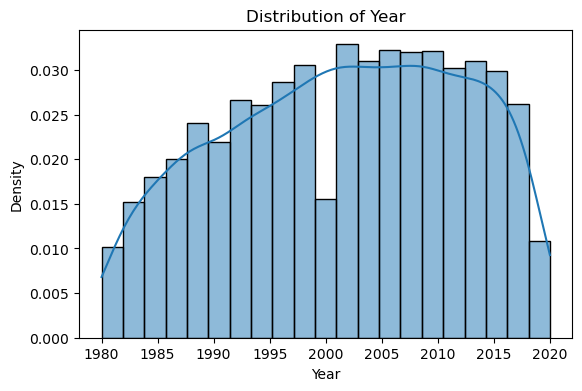

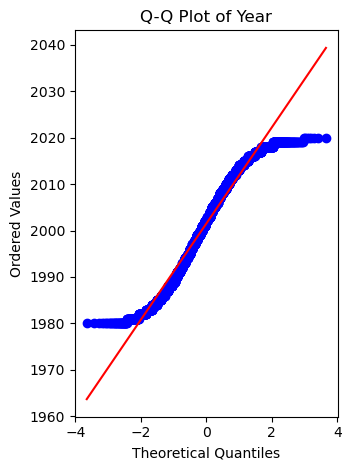

In [14]:
#Univariate Analysis of Year
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Year'], kde=True, stat='density')
plt.title('Distribution of Year')
plt.xlabel('Year')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Year'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Year')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()

plt.show()

Here is our graphs representing the univariate analysis of 'Year'

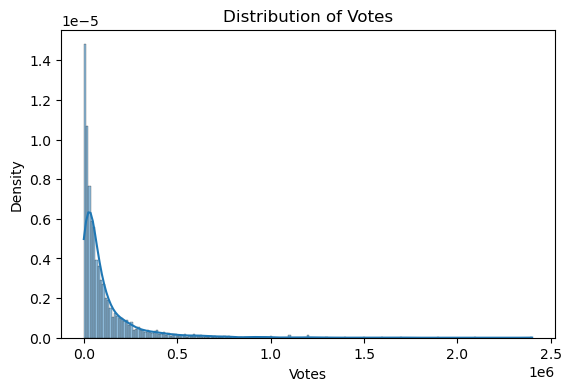

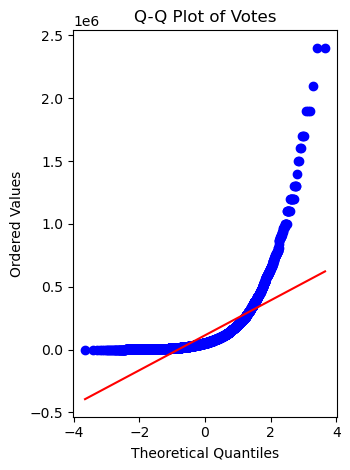

In [15]:
#Univariate Analysis of Votes
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Votes'], kde=True, stat='density')
plt.title('Distribution of Votes')
plt.xlabel('Votes')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Votes'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Votes')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Votes'

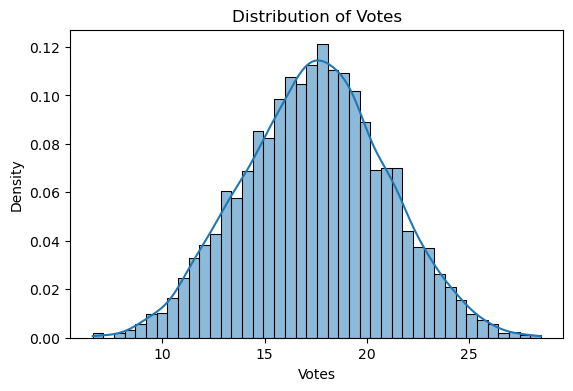

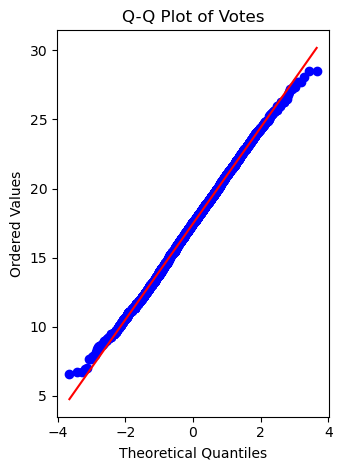

In [16]:
#Normalize the right skewed data
df['Votes'], lambda_votes = boxcox(df['Votes'])

plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Votes'], kde=True, stat='density')
plt.title('Distribution of Votes')
plt.xlabel('Votes')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Votes'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Votes')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Votes' after normalizing our data

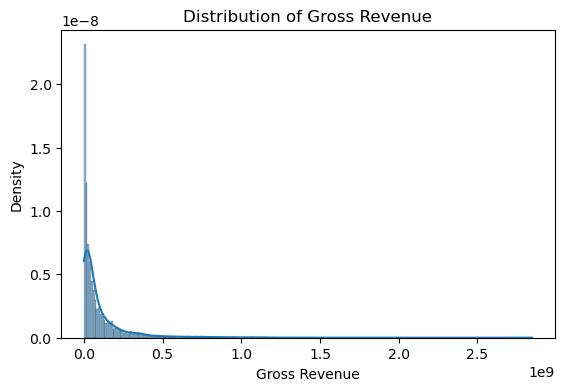

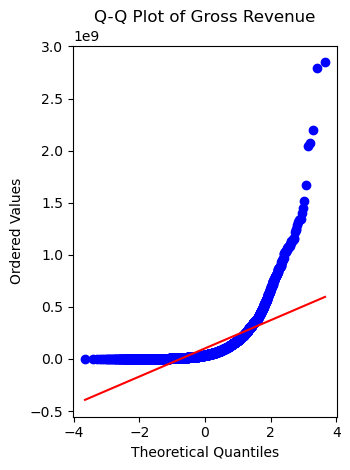

In [17]:
#Univariate Analysis of Gross Revenue
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Gross Revenue'], kde=True, stat='density')
plt.title('Distribution of Gross Revenue')
plt.xlabel('Gross Revenue')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Gross Revenue'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Gross Revenue')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Gross Revenue'

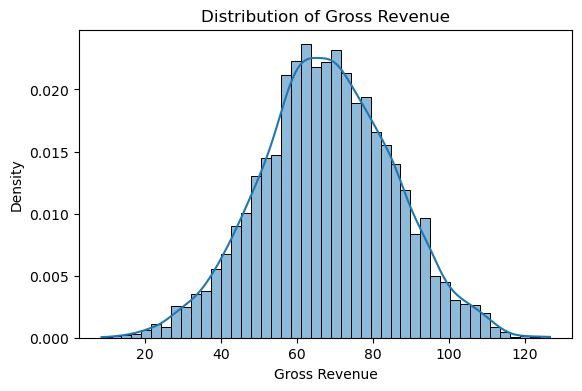

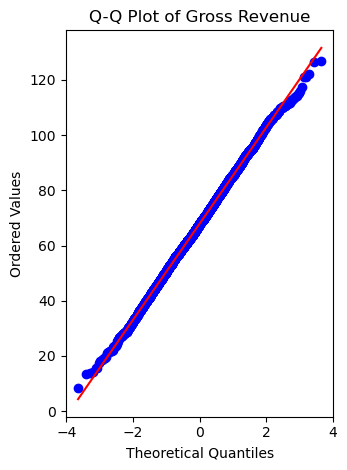

In [18]:
#Normalize the right skewed data
df['Gross Revenue'], lambda_gross = boxcox(df['Gross Revenue'])
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Gross Revenue'], kde=True, stat='density')
plt.title('Distribution of Gross Revenue')
plt.xlabel('Gross Revenue')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Gross Revenue'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Gross Revenue')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Gross Revenue' after normalizing it

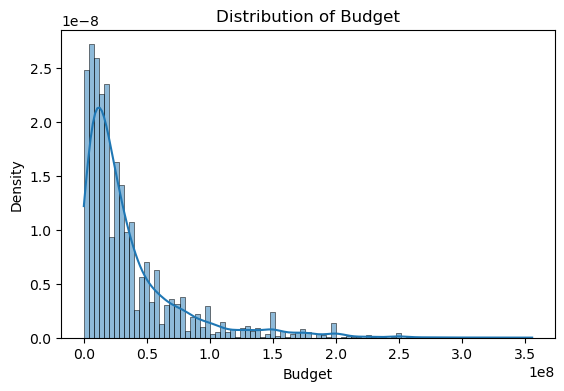

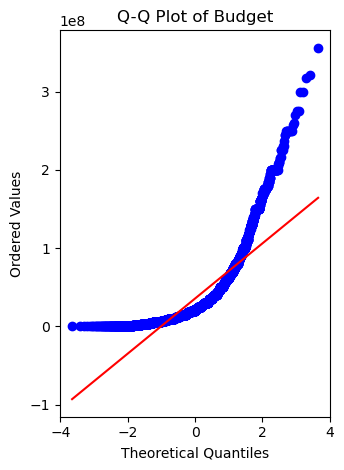

In [19]:
#Univariate Analysis of Budget
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Budget'], kde=True, stat='density')
plt.title('Distribution of Budget')
plt.xlabel('Budget')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Budget'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Budget')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Budget'

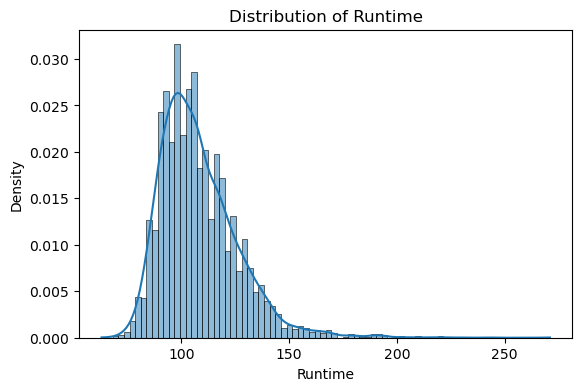

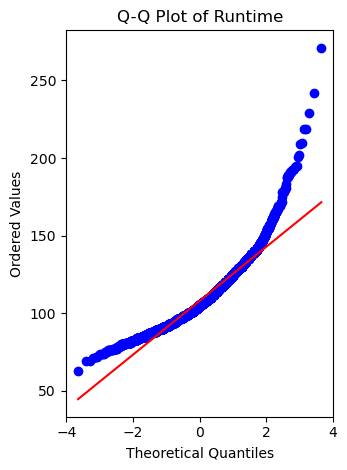

In [20]:
#Univariate Analysis of Runtime
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Runtime'], kde=True, stat='density')
plt.title('Distribution of Runtime')
plt.xlabel('Runtime')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Runtime'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Runtime')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Here is our graphs representing the univariate analysis of 'Runtime'

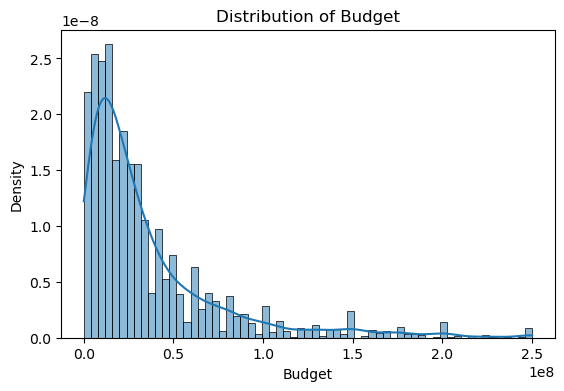

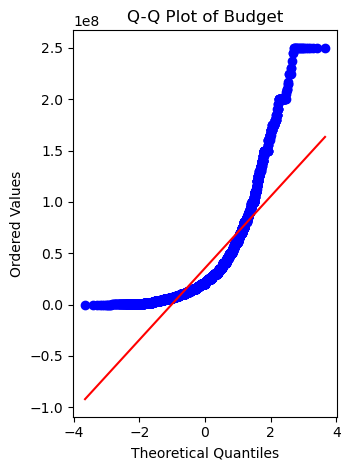

In [21]:
df['Budget'] = df['Budget'].apply(lambda x: 250000000 if x > 250000000 else x)

plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Budget'], kde=True, stat='density')
plt.title('Distribution of Budget')
plt.xlabel('Budget')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(df['Budget'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Budget')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()


Here is our graphs representing the univariate analysis of 'Budget' after we cap the values above 250,000,000 to 250,000,000

### Univariate Analysis (Categorical Variables)

In [22]:
print("Unique Value Count of Categorical Variables")
print("Rating:", len(df['Rating'].unique()))
print("Genre:",len(df['Genre'].unique()))
print("Director:",len(df['Director'].unique()))
print("Writer:",len(df['Writer'].unique()))
print("Star:",len(df['Star'].unique()))
print("Country:",len(df['Country'].unique()))
print("Company:",len(df['Company'].unique()))

Unique Value Count of Categorical Variables
Rating: 10
Genre: 15
Director: 2045
Writer: 3178
Star: 1830
Country: 50
Company: 1464


Text(0.5, 1.0, 'Mean Score by Rating')

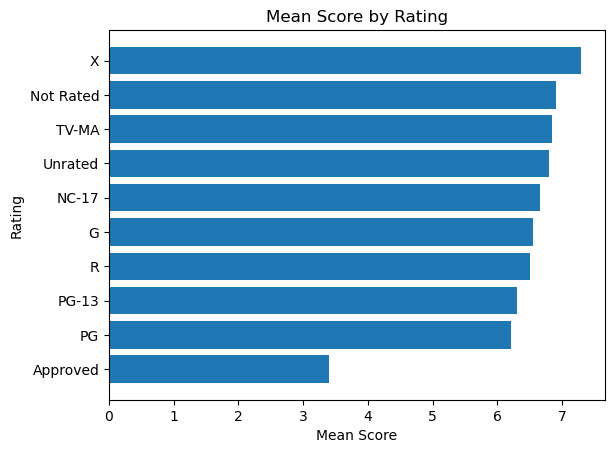

In [23]:
score_by_rating = df.groupby("Rating")["Score"].mean().sort_values(ascending=True)

plt.barh(score_by_rating.index, score_by_rating.values)
plt.xlabel('Mean Score')
plt.ylabel('Rating')
plt.title('Mean Score by Rating')

This horizontal bar chart displays the average scores for different content ratings of movies.

Text(0.5, 1.0, 'Mean Score by Genre')

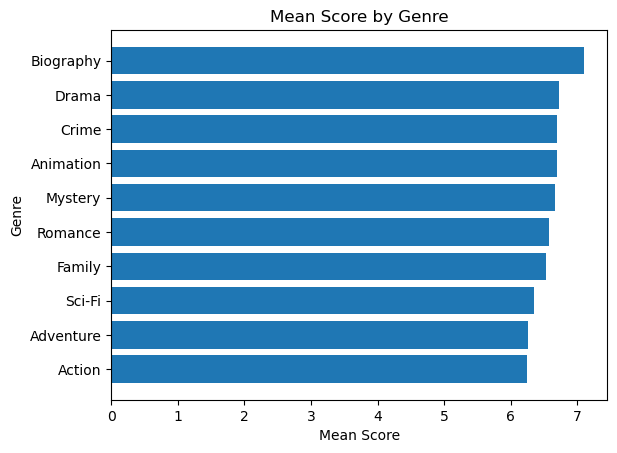

In [24]:
score_by_genre = df.groupby("Genre")["Score"].mean().sort_values(ascending=True)[len(df['Genre'].unique()) - 10 :]

plt.barh(score_by_genre.index, score_by_genre.values)
plt.xlabel('Mean Score')
plt.ylabel('Genre')
plt.title('Mean Score by Genre')

This horizontal bar chart displays the average scores for different movie genres.

Text(0.5, 1.0, 'Count by Genre')

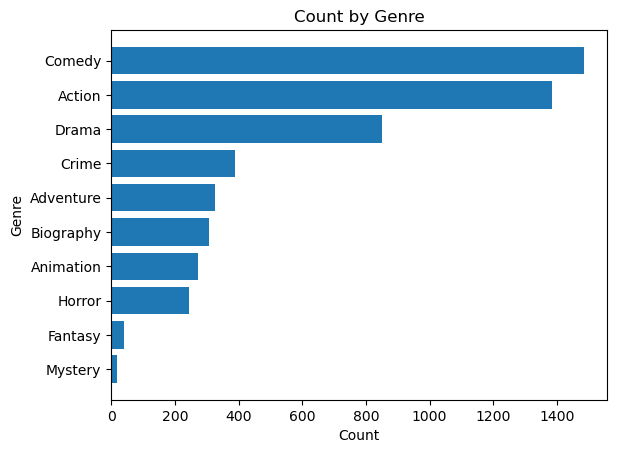

In [25]:
count_by_genre = df.groupby("Genre")["Score"].count().sort_values(ascending=True)[len(df['Genre'].unique()) - 10 :]

plt.barh(count_by_genre.index, count_by_genre.values)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Count by Genre')

The bar chart illustrates the distribution across various genres of movies.

Text(0.5, 1.0, 'Mean Score by Country')

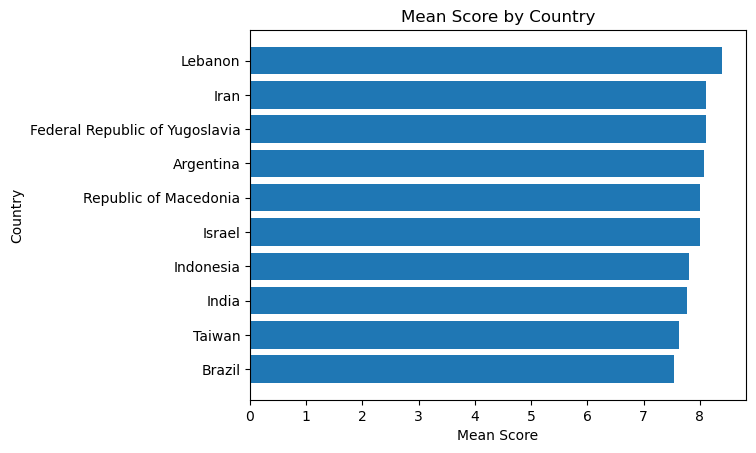

In [26]:
score_by_country = df.groupby("Country")["Score"].mean().sort_values(ascending=True)[len(df['Country'].unique()) - 10 :]

plt.barh(score_by_country.index, score_by_country.values)
plt.xlabel('Mean Score')
plt.ylabel('Country')
plt.title('Mean Score by Country')

This horizontal bar chart displays the average scores of movies released by various countries.

Text(0.5, 1.0, 'Count by Country')

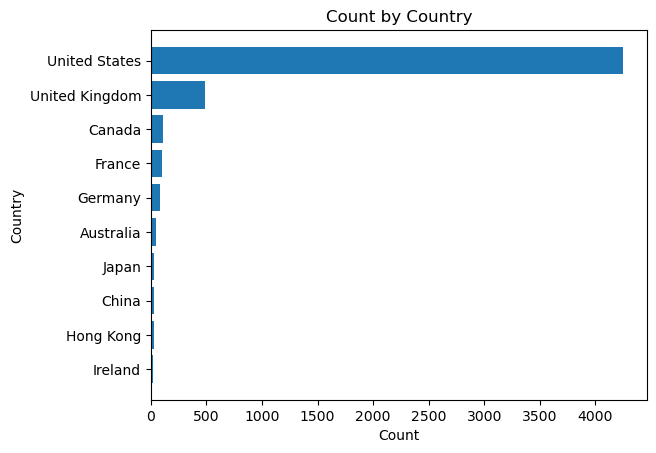

In [27]:
count_by_country = df.groupby("Country")["Score"].count().sort_values(ascending=True)[len(df['Country'].unique()) - 10 :]

plt.barh(count_by_country.index, count_by_country.values)
plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Count by Country')

This horizontal bar chart displays the number of movies released by various countries.

Text(0.5, 1.0, 'Mean Score by Company')

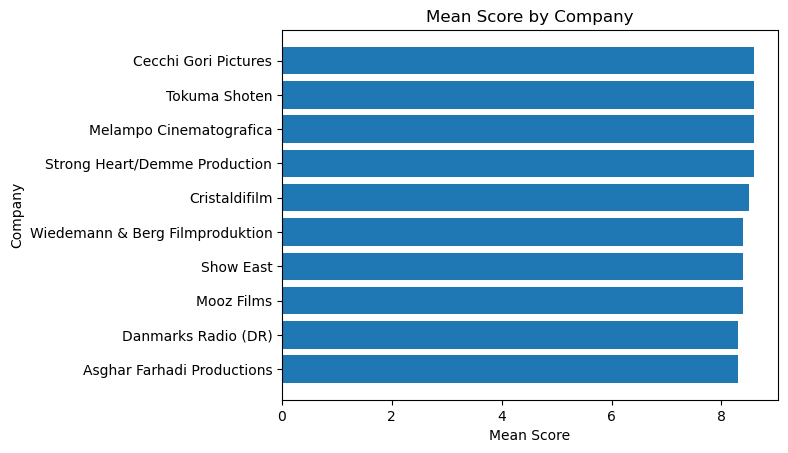

In [28]:
score_by_company = df.groupby("Company")["Score"].mean().sort_values(ascending=True)[len(df['Company'].unique()) - 10 :]

plt.barh(score_by_company.index, score_by_company.values)
plt.xlabel('Mean Score')
plt.ylabel('Company')
plt.title('Mean Score by Company')

This horizontal bar chart displays the average score released by various companies ordered from highest to lowest.

Text(0.5, 1.0, 'Mean Score by Company')

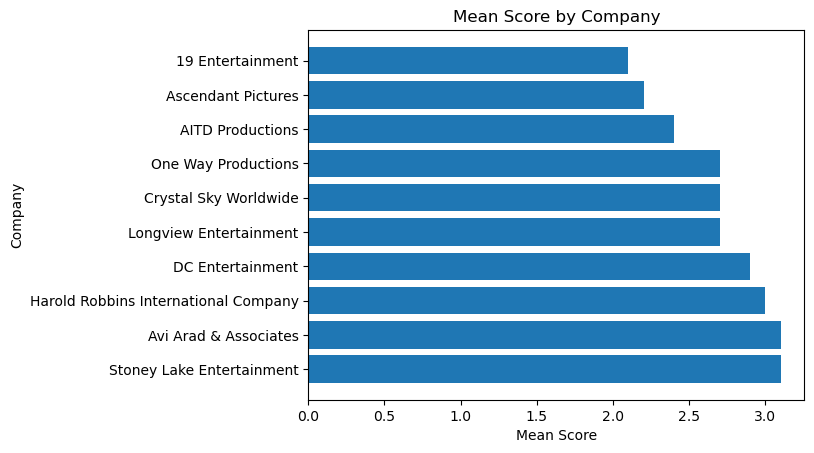

In [29]:
score_by_company = df.groupby("Company")["Score"].mean().sort_values(ascending=False)[len(df['Company'].unique()) - 10 :]

plt.barh(score_by_company.index, score_by_company.values)
plt.xlabel('Mean Score')
plt.ylabel('Company')
plt.title('Mean Score by Company')

This horizontal bar chart displays the average score released by various companies ordered in lowest to highest.

Text(0.5, 1.0, 'Count by Company')

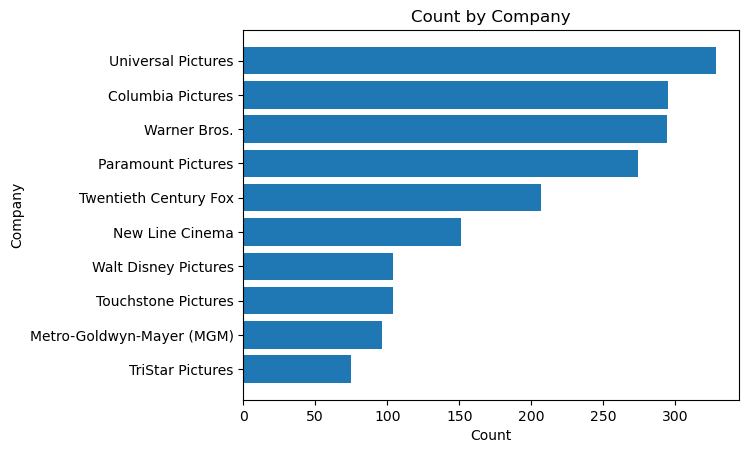

In [30]:
score_by_company = df.groupby("Company")["Score"].count().sort_values(ascending=True)[len(df['Company'].unique()) - 10 :]

plt.barh(score_by_company.index, score_by_company.values)
plt.xlabel('Count')
plt.ylabel('Company')
plt.title('Count by Company')

This horizontal bar chart displays the total count released by various companies.

### Data Transformation


In [31]:
# Instantiating MinMaxScaler and StandardScaler
scaler_minmax = MinMaxScaler()
scaler_std = StandardScaler()

# Scaling the columns
df[['Budget']] = scaler_minmax.fit_transform(df[['Budget']])
df[['Votes', 'Gross Revenue', 'Runtime']] = scaler_std.fit_transform(df[['Votes', 'Gross Revenue', 'Runtime']])

# Performing one-hot encoding on 'Rating', 'Genre', and 'Country' columns
oneHot = pd.get_dummies(df[['Rating', 'Genre', 'Country']], columns=['Rating', 'Genre', 'Country'])
df = pd.concat([df, oneHot], axis=1)
df.head()


,Name,Rating,Genre,Year,Released,Score,Votes,Director,Writer,Star,...,Country_Spain,Country_Sweden,Country_Switzerland,Country_Taiwan,Country_Thailand,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Country_West Germany,Country_Yugoslavia
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,2.294269,Stanley Kubrick,Stephen King,Jack Nicholson,...,0,0,0,0,0,0,1,0,0,0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,0.173770,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,...,0,0,0,0,0,0,0,1,0,0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,2.525956,Irvin Kershner,Leigh Brackett,Mark Hamill,...,0,0,0,0,0,0,0,1,0,0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,1.092990,Jim Abrahams,Jim Abrahams,Robert Hays,...,0,0,0,0,0,0,0,1,0,0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,0.543980,Harold Ramis,Brian Doyle-Murray,Chevy Chase,...,0,0,0,0,0,0,0,1,0,0


### Bivariate Analysis

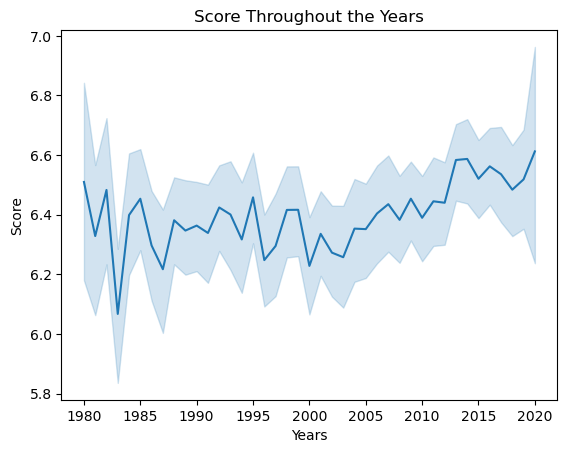

In [32]:
sns.lineplot(data=df, x="Year", y="Score")

plt.title('Score Throughout the Years')
plt.xlabel('Years')
plt.ylabel('Score')

# Show the plot
plt.show()

This is our graph representing the Bivariate analysis of 'Score' throughout the years

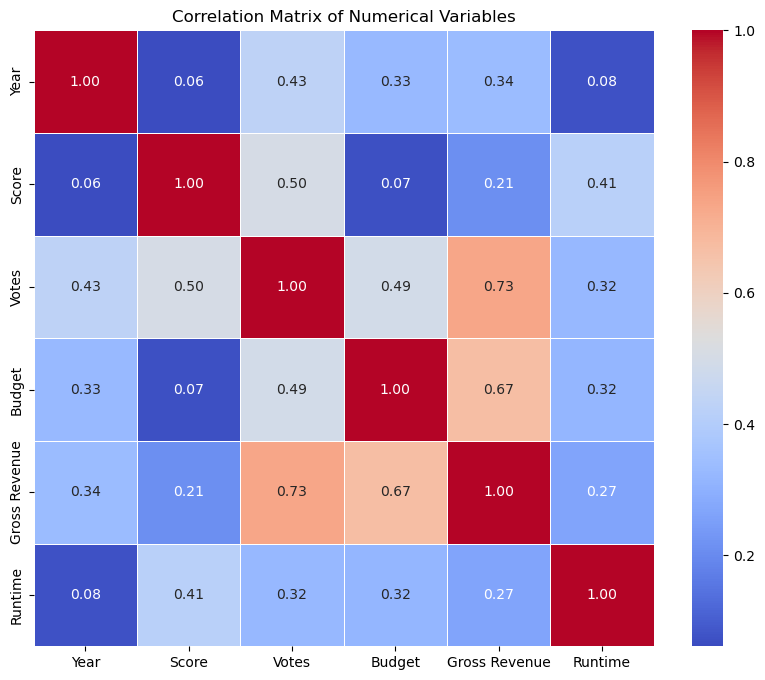

In [33]:
correlation_matrix = df[["Year", 'Score', "Votes", "Budget", "Gross Revenue", "Runtime"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Training Model 1: Polynomial Regression

This is our correlation matrix of attributes that have numerical values

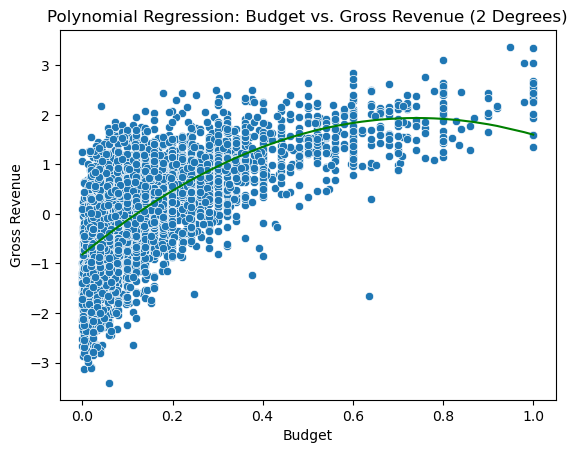

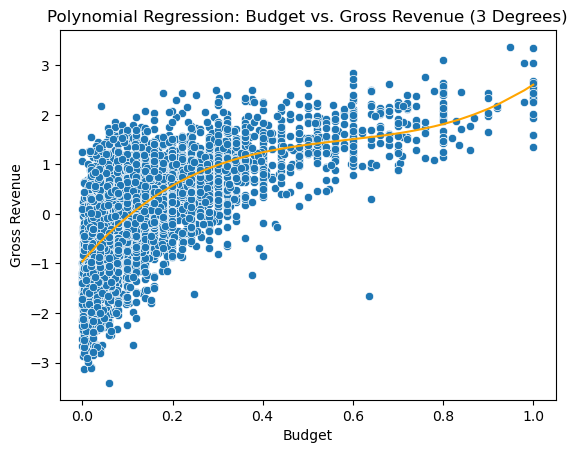

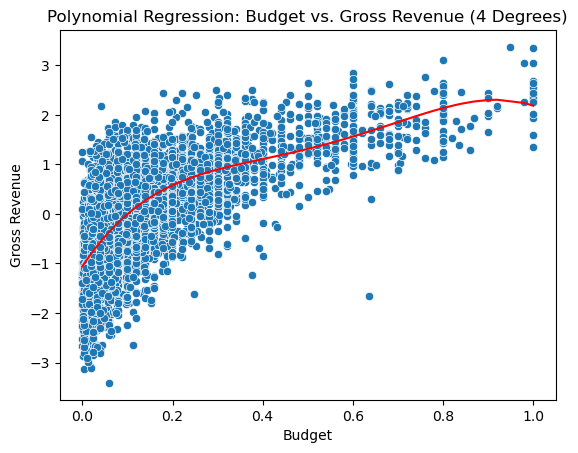

In [34]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

df_BGR = df[['Budget', 'Gross Revenue']]
X1_train, X1_test, y1_train, y1_test = train_test_split(df_BGR.Budget, df_BGR.drop(['Budget'], axis=1), test_size=0.2, random_state=21)

train = pd.concat([X1_train, y1_train], axis=1)
train = train.sort_values(by=['Budget'])
budget = train[['Budget']]
grossRevenue = train[['Gross Revenue']]

# 2 Degrees
poly2 = PolynomialFeatures(degree=2, include_bias=False)
polyX = poly2.fit_transform(budget)

linear = linear_model.LinearRegression()
linear.fit(polyX, grossRevenue)
yhat = linear.predict(polyX)

sns.scatterplot(data=df, x="Budget", y="Gross Revenue")
plt.plot(budget, yhat, color="green")
plt.title("Polynomial Regression: Budget vs. Gross Revenue (2 Degrees)")
plt.xlabel('Budget')
plt.ylabel('Gross Revenue')
plt.show()

# 3 Degrees
poly3 = PolynomialFeatures(degree=3, include_bias=False)
polyX = poly3.fit_transform(budget)

linear = linear_model.LinearRegression()
linear.fit(polyX, grossRevenue)
yhat = linear.predict(polyX)

sns.scatterplot(data=df, x="Budget", y="Gross Revenue")
plt.plot(budget, yhat, color="orange")
plt.title("Polynomial Regression: Budget vs. Gross Revenue (3 Degrees)")
plt.xlabel('Budget')
plt.ylabel('Gross Revenue')
plt.show()

# 3 Degrees
poly4 = PolynomialFeatures(degree=4, include_bias=False)
polyX = poly4.fit_transform(budget)

linear = linear_model.LinearRegression()
linear.fit(polyX, grossRevenue)
yhat = linear.predict(polyX)

sns.scatterplot(data=df, x="Budget", y="Gross Revenue")
plt.plot(budget, yhat, color="red")
plt.title("Polynomial Regression: Budget vs. Gross Revenue (4 Degrees)")
plt.xlabel('Budget')
plt.ylabel('Gross Revenue')
plt.show()


This is our graph representing the Bivariate analysis of 'Budget' vs 'Gross Reveue'

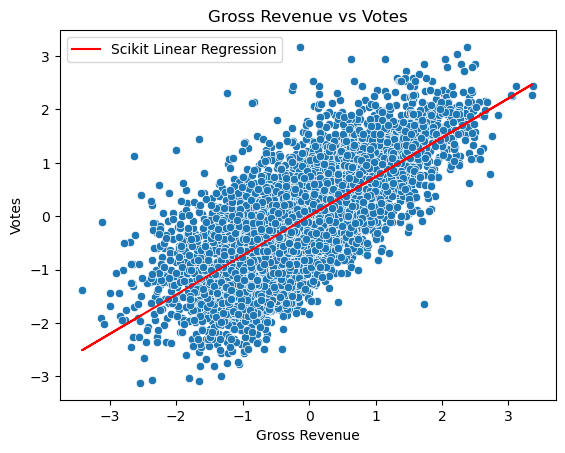

In [35]:
df_GRV = df[['Gross Revenue', 'Votes']]
X_train, X_test, y_train, y_test = train_test_split(df_GRV.drop(['Votes'], axis=1), df_GRV.Votes, test_size=0.2, random_state=21)

model = LinearRegression()
# Fit model to the data
model.fit(X_train, y_train)
# Predict Y values using the fitted model
Y_pred = model.predict(X_train)

# Plot the regression line
plt.plot(X_train, Y_pred, color='red', label='Scikit Linear Regression')
sns.scatterplot(data=df, x="Gross Revenue", y="Votes")
plt.title('Gross Revenue vs Votes')
plt.xlabel('Gross Revenue')
plt.ylabel('Votes')

plt.show()

This is our graph representing the Bivariate analysis of 'Gross Revenue' vs 'Votes'

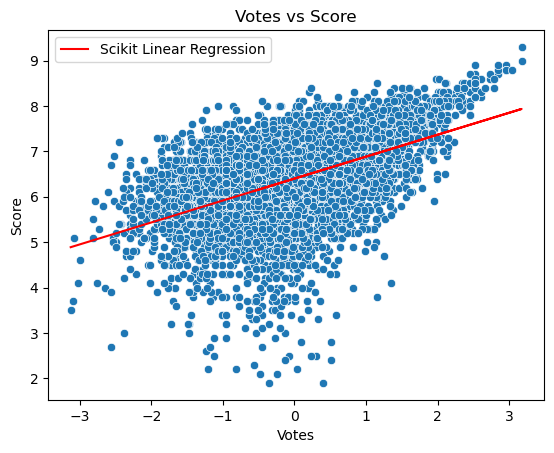

In [36]:
from sklearn import linear_model

df_VS = df[['Votes', 'Score']]
X_train, X_test, y_train, y_test = train_test_split(df_VS.drop(['Score'], axis=1), df_VS.Score, test_size=0.2, random_state=21)

model = LinearRegression()
# Fit model to the data
model.fit(X_train, y_train)
# Predict Y values using the fitted model
Y_pred = model.predict(X_train)

# Plot the regression line
plt.plot(X_train, Y_pred, color='red', label='Scikit Linear Regression')
sns.scatterplot(data=df, x="Votes", y="Score")
plt.title('Votes vs Score')
plt.xlabel('Votes')
plt.ylabel('Score')

plt.show()


This is our graph representing the Bivariate analysis of 'Vote' vs 'Score'

## Evaluate our First Model Compare Training vs Test Error

/Users/kennethhie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


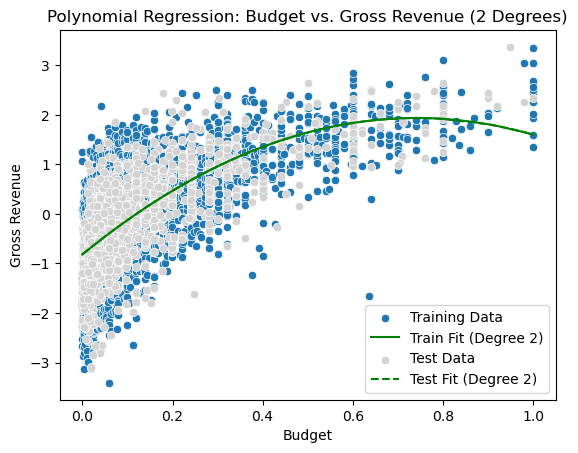

Degree 2 polynomial regression training MSE: 0.5122772510089513
Degree 2 polynomial regression testing MSE: 0.4805708428709708


/Users/kennethhie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


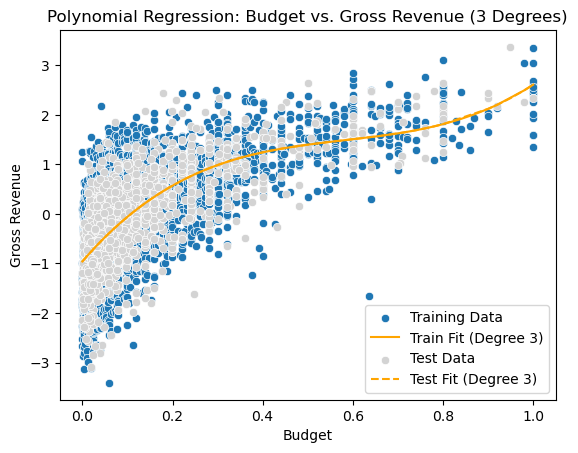

Degree 3 polynomial regression training MSE: 0.49835961308670407
Degree 3 polynomial regression testing MSE: 0.4681592613643696


/Users/kennethhie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


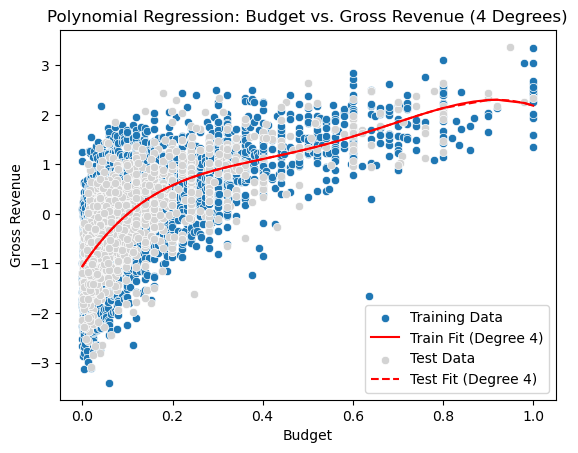

Degree 4 polynomial regression training MSE: 0.49328464588502247
Degree 4 polynomial regression testing MSE: 0.4652541124943731


In [37]:
# Function to evaluate and plot polynomial regression
def evaluate_poly_regression(degree, X_train, y_train, X_test, y_test, color):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    polyX_train = poly.fit_transform(X_train)
    polyX_test = poly.transform(X_test)
    
    linear = LinearRegression()
    linear.fit(polyX_train, y_train)
    
    # Predict on training and testing data
    yhat_train = linear.predict(polyX_train)
    yhat_test = linear.predict(polyX_test)
    
    # Calculate training and testing errors
    mse_train = mean_squared_error(y_train, yhat_train)
    mse_test = mean_squared_error(y_test, yhat_test)
    
    # Plotting for training data
    # Convert DataFrame/Series to numpy array and then flatten
    X_train_np = X_train.to_numpy().flatten() if hasattr(X_train, 'to_numpy') else X_train.flatten()
    y_train_np = y_train.to_numpy().flatten() if hasattr(y_train, 'to_numpy') else y_train.flatten()
    sns.scatterplot(x=X_train_np, y=y_train_np, label='Training Data')
    
    # Sort the values for better plotting
    sorted_train_indices = np.argsort(X_train_np)
    plt.plot(X_train_np[sorted_train_indices], yhat_train[sorted_train_indices], color=color, label=f'Train Fit (Degree {degree})')
    
    # Plotting for test data
    X_test_np = X_test.to_numpy().flatten() if hasattr(X_test, 'to_numpy') else X_test.flatten()
    y_test_np = y_test.to_numpy().flatten() if hasattr(y_test, 'to_numpy') else y_test.flatten()
    sns.scatterplot(x=X_test_np, y=y_test_np, label='Test Data', color='lightgrey')
    
    # Sort the values for better plotting
    sorted_test_indices = np.argsort(X_test_np)
    plt.plot(X_test_np[sorted_test_indices], yhat_test[sorted_test_indices], color=color, linestyle='--', label=f'Test Fit (Degree {degree})')
    plt.title(f"Polynomial Regression: Budget vs. Gross Revenue ({degree} Degrees)")
    plt.xlabel('Budget')
    plt.ylabel('Gross Revenue')
    plt.legend()
    plt.show()
    
    # Print errors
    print(f"Degree {degree} polynomial regression training MSE: {mse_train}")
    print(f"Degree {degree} polynomial regression testing MSE: {mse_test}")


# Evaluate and plot for 2 degrees
evaluate_poly_regression(2, budget, grossRevenue, X1_test.values.reshape(-1, 1), y1_test, "green")

# Evaluate and plot for 3 degrees
evaluate_poly_regression(3, budget, grossRevenue, X1_test.values.reshape(-1, 1), y1_test, "orange")

# Evaluate and plot for 4 degrees
evaluate_poly_regression(4, budget, grossRevenue, X1_test.values.reshape(-1, 1), y1_test, "red")

All three degrees 2, 3, and 4 are showing a good fit as seen by the testing MSE being lower than or very close to the training MSE. There is no evidence of overfitting, where we would expect the testing MSE to be significantly higher than the training MSE due to the model capturing noise in the training data.

## Model Fit In The Fitting Graph

Based on our MSE values, as the polynomial degree increases from 2 to 4, both training and testing MSEs decrease. This indicates that our model is capturing more of the data's underlying pattern with increased complexity, improving its performance. Our model with polynomial degree 4 have the lowest MSEs suggests an optimal balance between bias and variance, making it the best fit among the ones that we tested. There's no sign of overfitting as both training and testing error decreases together. In conclusion, our polynomial regression model with degree 4 provides the best balance of complexity and performance based on our data.

## Next 2 models

In light of the insights derived from the performance of our current neural network model, we are considering the exploration of two additional machine learning models to potentially enhance our predictive capabilities and address the identified limitations:

- **Neural Network**: Neural networks are indeed well-suited to handle the complexity inherent in modeling the relationship between a movie's budget and its gross revenue, thanks to their ability to model nonlinear relationships and interactions between features without the need for manual feature engineering. Unlike polynomial regression, which requires choosing the degree of polynomials a priori and risks overfitting with higher degrees, neural networks can learn complex patterns through their hidden layers and neurons. They do this by adjusting weights and biases through backpropagation based on the error rate, allowing them to capture both high-level and subtle nuances in data. Moreover, neural networks can automatically discover the interaction between variables, making them a powerful tool for capturing the multifaceted dynamics of movie revenues. The flexibility and adaptability of neural networks, combined with techniques to prevent overfitting such as dropout and regularization, make them an attractive option for improving upon traditional regression models in predicting outcomes with complex, non-linear relationships.

- **Decision Tree Classifier**: Despite the simplicity of decision trees, they are powerful for classification tasks and provide clear visualization of the decision-making process. A key advantage of using a Decision Tree Classifier is its interpretability; it allows for easy understanding of how decisions are made, which is invaluable for analyzing which features most significantly affect a movie's success. Furthermore, decision trees can handle non-linear data effectively and are less susceptible to outliers than regression models, making them a suitable choice for further exploration.

These models were chosen with the intention of addressing specific challenges observed in our initial approach. Polynomial regression will allow us to test the hypothesis that a more nuanced modeling of relationships between variables could yield better predictive performance. On the other hand, the Decision Tree Classifier offers a different approach to classification, with the potential for higher accuracy.

## What is the conclusion of your 1st model?

The improvement in MSE as the degree of the polynomial increases suggests that the relationship between budget and gross revenue is complex and potentially non-linear, with higher-degree polynomials capturing this complexity more effectively. The consistent decrease in both training and testing errors indicates that the model is not yet suffering from overfitting at the fourth degree.

However, it's important to note that while the improvements in MSE are consistent, they are also marginal, especially when moving from degree 3 to degree 4. This diminishing return suggests that there is a limit to how much more complexity (in terms of polynomial degree) can beneficially be added to the model without overfitting. The observation of diminishing returns as we increase the polynomial degree suggests a critical insight into the nature of modeling complex relationships, such as that between a movie's budget and its gross revenue. It emphasizes the inherent trade-offs in model development, especially between capturing the underlying data patterns (reducing bias) and maintaining a model's ability to generalize well to unseen data (avoiding overfitting).

The fact that the model is not yet overfitting at the fourth degree is encouraging, indicating there's still some, albeit limited, scope for complexity increase without sacrificing model performance on new data. However, the marginal gains observed caution us against pursuing higher degrees of polynomial without careful consideration. It suggests that we are approaching, if not already at, the point of optimal complexity where the model is sufficiently complex to capture the relevant patterns in the data but not so complex that it becomes overly specialized to the training set.

This situation underscores the importance of exploring alternative strategies for model improvement that do not solely rely on increasing model complexity through higher-degree polynomials. Techniques such as incorporating domain knowledge to engineer more relevant features, employing regularization methods to penalize unnecessary complexity, and exploring other forms of model validation like cross-validation to ensure that improvements are robust and generalizable, become paramount.

Moreover, this context also highlights the potential utility of exploring other modeling approaches that might inherently balance complexity and generalizability better. Machine learning models, such as random forests, gradient boosting machines, or neural networks, offer sophisticated mechanisms to model non-linear relationships and interactions without manually specifying the form of the model. These models come with their mechanisms to control overfitting, such as depth limitations in trees or dropout in neural networks, potentially providing a more effective way to capture the complexities of the relationship between movie budgets and gross revenue while maintaining good performance on unseen data.

## What can be done to possibly to improve it?

- **Regularization**: To prevent overfitting, especially when using higher-degree polynomials, consider applying regularization techniques such as Ridge or Lasso regression. These methods can help control the complexity of the model by penalizing large coefficients.

- **Feature Engineering**: Besides polynomial features, explore other forms of feature engineering. For instance, interaction terms between budget and other variables might provide additional insights. Also, normalizing or scaling the features might help, especially when moving towards models that use regularization.

- **Alternative Models**: Consider exploring non-linear models beyond polynomials, such as decision trees, random forests, or gradient boosting machines, which might capture the data's complexity in different ways.

- **Hyperparameter Tuning**: Use grid search or random search to find the optimal combination of hyperparameters, such as the degree of the polynomial and regularization strength. This systematic approach can help in identifying the best model configuration.

- **Non-Linear Transformations**: Before applying polynomial features, consider non-linear transformations on the input features, such as logarithmic, square root, or exponential transformations. These transformations can help in linearizing relationships between features and the target variable.


# Train Model 2: Neural Network Model

### Data Preprocessing

In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# First, let's define the function to classify scores
def classify_score(score):
    if score <= 3:
        return 'very bad'
    elif score <= 5:
        return 'bad'
    elif score <= 8:
        return 'mid'
    else:
        return 'good'

# Create a new column 'group_rating' based on the score
df['group_rating'] = df['Score'].apply(classify_score)

# Selecting the required columns for features and target variable
X_movies = df[['Budget', 'Gross Revenue']]  # Features: budget and gross revenue
y_movies = df['group_rating']  # Target variable is now 'group_rating'

# Apply one-hot encoding to the target variable (rating)
encoder_movies = OneHotEncoder()
y_movies_encoded = encoder_movies.fit_transform(y_movies.values.reshape(-1, 1)).toarray()

# Apply min-max normalization to the 'budget' and 'gross' features
scaler_movies = MinMaxScaler()
X_movies_scaled = scaler_movies.fit_transform(X_movies)

df

,Name,Rating,Genre,Year,Released,Score,Votes,Director,Writer,Star,...,Country_Sweden,Country_Switzerland,Country_Taiwan,Country_Thailand,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Country_West Germany,Country_Yugoslavia,group_rating
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,2.294269,Stanley Kubrick,Stephen King,Jack Nicholson,...,0,0,0,0,0,1,0,0,0,good
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,0.173770,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,...,0,0,0,0,0,0,1,0,0,mid
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,2.525956,Irvin Kershner,Leigh Brackett,Mark Hamill,...,0,0,0,0,0,0,1,0,0,good
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,1.092990,Jim Abrahams,Jim Abrahams,Robert Hays,...,0,0,0,0,0,0,1,0,0,mid
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,0.543980,Harold Ramis,Brian Doyle-Murray,Chevy Chase,...,0,0,0,0,0,0,1,0,0,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7648,Bad Boys for Life,R,Action,2020,"January 17, 2020 (United States)",6.600000,0.739239,Adil El Arbi,Peter Craig,Will Smith,...,0,0,0,0,0,0,1,0,0,mid
7649,Sonic the Hedgehog,PG,Action,2020,"February 14, 2020 (United States)",6.500000,0.501529,Jeff Fowler,Pat Casey,Ben Schwartz,...,0,0,0,0,0,0,1,0,0,mid
7650,Dolittle,PG,Adventure,2020,"January 17, 2020 (United States)",5.600000,0.029252,Stephen Gaghan,Stephen Gaghan,Robert Downey Jr.,...,0,0,0,0,0,0,1,0,0,mid
7651,The Call of the Wild,PG,Adventure,2020,"February 21, 2020 (United States)",6.800000,-0.132540,Chris Sanders,Michael Green,Harrison Ford,...,0,0,0,0,0,0,0,0,0,mid


### Training and Testing the Neural Network

In [39]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# Split the data into training and testing sets with a 90:10 ratio
X_train, X_test, y_train, y_test = train_test_split(X_movies_scaled, y_movies_encoded, test_size=0.1, random_state=42)

MFXACTIVATION ='relu'

model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation= MFXACTIVATION),  # Increased complexity and changed to ReLU
    Dense(32, activation=MFXACTIVATION),  # ReLU activation
    Dense(16, activation=MFXACTIVATION),  # ReLU activation
    Dense(8, activation=MFXACTIVATION),  # ReLU activation
    Dense(y_train.shape[1], activation='sigmoid')  # Output layer remains the same
])

optimizer = SGD(learning_rate=0.001)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate metrics
cm = confusion_matrix(y_test_classes, y_pred_classes)
acc = accuracy_score(y_test_classes, y_pred_classes)
mse = mean_squared_error(y_test, y_pred)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)

# Output the metrics
print("Confusion Matrix:", cm)
print("Accuracy:", acc)
print("MSE:", mse)
print("Precision:", precision)
print("Recall:", recall)

Epoch 1/100


/Users/kennethhie/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9025 - loss: 1.2259 - val_accuracy: 0.9002 - val_loss: 1.0030
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8865 - loss: 0.9617 - val_accuracy: 0.9002 - val_loss: 0.7895
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8950 - loss: 0.7678 - val_accuracy: 0.9002 - val_loss: 0.6563
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8936 - loss: 0.6585 - val_accuracy: 0.9002 - val_loss: 0.5784
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8935 - loss: 0.5953 - val_accuracy: 0.9002 - val_loss: 0.5341
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9044 - loss: 0.5270 - val_accuracy: 0.9002 - val_loss: 0.5101
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.5481 - val_accuracy: 0.9002 - val_loss: 0.4939
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8880 - loss: 0.5484 - val_accuracy: 0.9002

Epoch 51/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9023 - loss: 0.4064 - val_accuracy: 0.9002 - val_loss: 0.3899
Epoch 52/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8973 - loss: 0.4206 - val_accuracy: 0.9002 - val_loss: 0.3899
Epoch 53/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.8973 - loss: 0.4231 - val_accuracy: 0.9002 - val_loss: 0.3896
Epoch 54/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8962 - loss: 0.4264 - val_accuracy: 0.9002 - val_loss: 0.3887
Epoch 55/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.8929 - loss: 0.4334 - val_accuracy: 0.9002 - val_loss: 0.3880
Epoch 56/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8959 - loss: 0.4236 - val_accuracy: 0.9002 - val_loss: 0.3874
Epoch 57/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.8910 - loss: 0.4462 - val_accuracy: 0.9002 - val_loss: 0.3868
Epoch 58/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.8928 - loss: 0

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8863 - loss: 0.4411 - val_accuracy: 0.9002 - val_loss: 0.3766
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix: [[  0   0  38]
 [  0   0   9]
 [  0   0 487]]
Accuracy: 0.9119850187265918
MSE: 0.08109181504133743
Precision: 0.831716674381742
Recall: 0.9119850187265918


### k-fold Cross Validation

In [ ]:
# Function to build the model, adapted for the Kaggle movie dataset
def build_movie_model():
    MFXACTIVATION ='relu'
    model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation= MFXACTIVATION),  # Increased complexity and changed to ReLU
    Dense(32, activation=MFXACTIVATION),  # ReLU activation
    Dense(16, activation=MFXACTIVATION),  # ReLU activation
    Dense(8, activation=MFXACTIVATION),  # ReLU activation
    Dense(y_train.shape[1], activation='sigmoid')  # Output layer remains the same
    ])
    model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    return model

# Wrap the Keras model with KerasClassifier
estimator_movies = KerasClassifier(model=build_movie_model, epochs=100, batch_size=10, verbose=1)  # Adjust verbosity as needed

# Define the cross-validation strategy
kfold_movies = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)

# Perform cross-validation for accuracy and MSE
results_movies = cross_validate(estimator_movies, X_movies_scaled, y_movies_encoded, cv=kfold_movies, scoring=['accuracy', 'neg_mean_squared_error'], n_jobs=1)

# Output results
print("Cross-validation results:")
print(results_movies)

Epoch 1/100


/Users/kennethhie/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6203 - loss: 1.3374 - mse: 0.2432
Epoch 2/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.8997 - loss: 1.0956 - mse: 0.2127
Epoch 3/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.8953 - loss: 0.9267 - mse: 0.1910
Epoch 4/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.8933 - loss: 0.8005 - mse: 0.1740
Epoch 5/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.8851 - loss: 0.7145 - mse: 0.1615
Epoch 6/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.8918 - loss: 0.6342 - mse: 0.1494
Epoch 7/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.8956 - loss: 0.5743 - mse: 0.1396
Epoch 8/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.8852 - loss: 0.5495 - mse: 0.1336
Epoch 9/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.9042 - loss: 0.4823 - mse: 0.1230
Epoch 10/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.8882 - loss: 0.49

481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8948 - loss: 0.4174 - mse: 0.1234
Epoch 61/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.8951 - loss: 0.4162 - mse: 0.1233
Epoch 62/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.8986 - loss: 0.4008 - mse: 0.1222
Epoch 63/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.8899 - loss: 0.4305 - mse: 0.1254
Epoch 64/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.8926 - loss: 0.4202 - mse: 0.1245
Epoch 65/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.8998 - loss: 0.3960 - mse: 0.1222
Epoch 66/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.8978 - loss: 0.4020 - mse: 0.1230
Epoch 67/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.8959 - loss: 0.4072 - mse: 0.1236
Epoch 68/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.8921 - loss: 0.4271 - mse: 0.1256
Epoch 69/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.8960 - lo

/Users/kennethhie/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.6801 - loss: 1.3337 - mse: 0.2438
Epoch 2/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.8964 - loss: 1.1006 - mse: 0.2142
Epoch 3/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.8968 - loss: 0.9333 - mse: 0.1931
Epoch 4/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.9002 - loss: 0.8074 - mse: 0.1768
Epoch 5/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.8992 - loss: 0.7186 - mse: 0.1649
Epoch 6/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.8957 - loss: 0.6582 - mse: 0.1562
Epoch 7/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.8878 - loss: 0.6231 - mse: 0.1505
Epoch 8/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.8948 - loss: 0.5764 - mse: 0.1435
Epoch 9/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.8961 - loss: 0.5465 - mse: 0.1385
Epoch 10/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.8979 - loss: 0.

481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.8874 - loss: 0.4433 - mse: 0.1135
Epoch 61/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.9006 - loss: 0.4051 - mse: 0.1104
Epoch 62/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.8989 - loss: 0.4089 - mse: 0.1111
Epoch 63/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.8931 - loss: 0.4303 - mse: 0.1135
Epoch 64/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.8913 - loss: 0.4295 - mse: 0.1137
Epoch 65/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8918 - loss: 0.4309 - mse: 0.1143
Epoch 66/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.8991 - loss: 0.4070 - mse: 0.1125
Epoch 67/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8864 - loss: 0.4443 - mse: 0.1163
Epoch 68/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8930 - loss: 0.4235 - mse: 0.1148
Epoch 69/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8965 - loss: 0.

/Users/kennethhie/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8890 - loss: 1.0624 - mse: 0.2129
Epoch 2/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8970 - loss: 0.5240 - mse: 0.1401
Epoch 3/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8894 - loss: 0.4743 - mse: 0.1201
Epoch 4/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8798 - loss: 0.4876 - mse: 0.1149
Epoch 5/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8892 - loss: 0.4512 - mse: 0.1081
Epoch 6/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8893 - loss: 0.4423 - mse: 0.1072
Epoch 7/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9006 - loss: 0.4097 - mse: 0.1040
Epoch 8/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8950 - loss: 0.4230 - mse: 0.1067
Epoch 9/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8943 - loss: 0.4231 - mse: 0.1073
Epoch 10/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8970 - loss: 0.4093 - mse: 0.1069
E

481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8987 - loss: 0.4003 - mse: 0.1213
Epoch 62/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.8946 - loss: 0.4149 - mse: 0.1233
Epoch 63/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8969 - loss: 0.4142 - mse: 0.1236
Epoch 64/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.8978 - loss: 0.4041 - mse: 0.1228
Epoch 65/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.8969 - loss: 0.4069 - mse: 0.1228
Epoch 66/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.8942 - loss: 0.4134 - mse: 0.1236
Epoch 67/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.8996 - loss: 0.3983 - mse: 0.1217
Epoch 68/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.8981 - loss: 0.4065 - mse: 0.1226
Epoch 69/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.8922 - loss: 0.4211 - mse: 0.1247
Epoch 70/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.8969 - loss

/Users/kennethhie/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.7189 - loss: 1.2893 - mse: 0.2419
Epoch 2/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.8915 - loss: 0.8229 - mse: 0.2070
Epoch 3/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.8931 - loss: 0.5338 - mse: 0.1901
Epoch 4/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.8911 - loss: 0.4529 - mse: 0.1846
Epoch 5/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.8979 - loss: 0.4168 - mse: 0.1813
Epoch 6/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9027 - loss: 0.3953 - mse: 0.1804
Epoch 7/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.8973 - loss: 0.4075 - mse: 0.1824
Epoch 8/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.8876 - loss: 0.4420 - mse: 0.1870
Epoch 9/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.8935 - loss: 0.4205 - mse: 0.1867
Epoch 10/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.9041 - loss: 0.

481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.9005 - loss: 0.4004 - mse: 0.2239
Epoch 61/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8976 - loss: 0.4039 - mse: 0.2244
Epoch 62/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8926 - loss: 0.4179 - mse: 0.2252
Epoch 63/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.8984 - loss: 0.4037 - mse: 0.2245
Epoch 64/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.9013 - loss: 0.3948 - mse: 0.2240
Epoch 65/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.9031 - loss: 0.3885 - mse: 0.2237
Epoch 66/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.9091 - loss: 0.3726 - mse: 0.2228
Epoch 67/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.8947 - loss: 0.4176 - mse: 0.2261
Epoch 68/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9011 - loss: 0.3976 - mse: 0.2246
Epoch 69/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.8942 - loss

/Users/kennethhie/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6728 - loss: 1.3196 - mse: 0.2417
Epoch 2/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.8963 - loss: 1.0607 - mse: 0.2082
Epoch 3/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.9028 - loss: 0.8577 - mse: 0.1834
Epoch 4/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.8984 - loss: 0.7094 - mse: 0.1648
Epoch 5/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.9009 - loss: 0.5933 - mse: 0.1495
Epoch 6/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.8995 - loss: 0.5223 - mse: 0.1387
Epoch 7/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.8974 - loss: 0.4841 - mse: 0.1313
Epoch 8/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.8910 - loss: 0.4743 - mse: 0.1270
Epoch 9/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.8997 - loss: 0.4329 - mse: 0.1201
Epoch 10/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.8988 - loss: 0.43

In [ ]:
# Assuming 'results_movies' contains the cross-validation results from the previous step
cv_accuracy_movies = results_movies['test_accuracy']
cv_mse_movies = -1 * results_movies['test_neg_mean_squared_error']  # Multiply by -1 to make MSE positive

# Print accuracy and MSE values for each fold
for i in range(len(cv_accuracy_movies)):
    print(f"Fold {i+1}: Accuracy = {cv_accuracy_movies[i]}, MSE = {cv_mse_movies[i]}")

# Print the overall average accuracy and MSE for the Kaggle movie dataset
print(f"Overall Average Accuracy: {np.mean(cv_accuracy_movies)}")
print(f"Overall Average MSE: {np.mean(cv_mse_movies)}")


### Hyperparameter Tuning

In [ ]:
# Split the data
X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(X_movies_scaled, y_movies_encoded, test_size=0.1, random_state=42)
def build_hp_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=12, max_value=512, step=100),
                    activation='relu',
                    input_dim=X_train_hp.shape[1]))
    model.add(Dense(units=hp.Int('units_layer2', min_value=12, max_value=512, step=100), activation='relu'))
    model.add(Dense(units=hp.Int('units_layer3', min_value=12, max_value=512, step=100), activation='relu')) # changed to relu to match previous models
    model.add(Dense(units=hp.Int('units_layer4', min_value=12, max_value=512, step=100), activation='relu'))

    model.add(Dense(y_train_hp.shape[1], activation='sigmoid'))  # Adapted for multi-class classification

    # Tune the learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(optimizer=SGD(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
# Define the tuner
# tuner = kt.Hyperband(
#     build_hp_model,
#     objective='val_accuracy',
#     max_epochs=10,
#     hyperband_iterations=15,
#     directory='tuner_results',
#     project_name='kaggle_movie_tuning'
# )

# Define the tuner
tuner = kt.GridSearch(
    hypermodel=build_hp_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    seed=15,
    tune_new_entries=True,
    allow_new_entries=True,
    directory='tuner_results',
    project_name='kaggle_movie_tuning'
)

# Run the hyperparameter search
tuner.search(X_train_hp, y_train_hp, epochs=50, validation_split=0.1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
The optimal number of units in the first hidden layer is {best_hps.get('units')}
with an optimal learning rate of {best_hps.get('learning_rate')}.
""")

# we used early stopping in earlier versions of our sequential model, so we decide to use it
early_stopping = EarlyStopping(
    monitor='val_accuracy', # or 'val_loss' if you prefer to monitor loss
    patience=10,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)

# Build the model with the optimal hyperparameters and evaluate it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_hp, y_train_hp, epochs=100, validation_data=(X_test_hp, y_test_hp), callbacks=[early_stopping])

## Evaluate our model compare training vs test error

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
# Calculate metrics
cm = confusion_matrix(y_test_classes, y_pred_classes)
acc = accuracy_score(y_test_classes, y_pred_classes)
mse = mean_squared_error(y_test, y_pred)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division=0)

# Output the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", acc)
print("MSE:", mse)
print("Precision:", precision)
print("Recall:", recall)

**Model Accuracy graph**: The accuracy for both training and validation shoots up sharply and reaches a high level after the first epoch. After the initial jump, the accuracy for both remains approximately constant. It's noteworthy that the validation accuracy is slightly higher than the training accuracy, which is unusual but not necessarily a problem if the variance is small. This could sometimes happen due to the specific samples in the validation set or regularization effects.

**Model Loss graph**: The loss for both training and validation decreases sharply after the first epoch and continues to decrease gradually over subsequent epochs. The training and validation losses are very close to each other and converge towards a similar value, which indicates that the model is generalizing well without overfitting or underfitting. There's no sign of divergence, which is good.

**Confusion Matrix**: The confusion matrix indicates that our model did not correctly predict any of the samples for the first two classes, but predicted all samples that belonged to the third class. The model correctly identified 487 samples of the third class, which indicates that it has a strong bias towards this class.

**MSE**: The MSE is around 0.074, which might seem low, but MSE is not typically the best metric for classification problems, especially when dealing with categorical data.

**Accuracy**: The accuracy which is about 91.2% which is a bit misleading in this context, as it seems the model has learned to predict the majority class very well but fails to recognize the other classes.

**Precision**: The precision score is about 83.2%. This suggests that when the model predicts a class, it's correct about 83.2% of the time. However, this metric is weighted and might be influenced by the class imbalance.

**Recall**: The recall is equal to the accuracy. This means that the model is very good at detecting the positives of the third class. However, for the first two classes, the recall is 0% because the model failed to identify any true positives for these classes.

In conclusion, the model is likely suffering from a class imbalance issue, where it predicts the majority class well but fails to predict the minority classes. This is evidenced by the lack of true positives for the two classes in the confusion matrix.

## Model Fit In The Fitting Graph, How does it compare to your first model? 

The model has a high accuracy, precision and recall on both the training and validation data, which would suggest a good fit. This suggests that our second model performs well in predicting the "group ratings" based on the "Gross Revenue" and "Budget" of the movie and we can determine that "Gross Revenue" and "Budget" are good features in order to predict our target variable "group rating". 

The fitting graphs with MSE values for the polynomial regression indicate that the model's performance varies with the degree of the polynomial. As the degree increases, the model fits the training data better but could potentially overfit. While our second model shows high classification accuracy, the fitting graphs from our first model indicate the regression model's capability to predict a continuous outcome based on its input. They serve different purposes and thus, their performances are not directly comparable.

In conclusion, for the specific task of classifying movies into 'group ratings', your second model seems to have found a good balance and performs well according to the classification metrics. For the task of predicting 'Gross Revenue' from 'Budget', the regression analysis of our first model indicates a variable fit depending on the polynomial degree, and its performance should be assessed by how well it generalizes to new, unseen data.

## Did you perform hyper parameter tuning? K-fold Cross validation? Feature expansion? What were the results? 

We performed, Hyper parameter tuning and K-fold Corss validation, but we didn't did any feature expansion as what we did was grouping scores. What we did with Grouping scores mean that We transformed the continuous 'Score' variable into a categorical 'group_rating' variable. This process is a form of feature engineering, where we're creating a new feature based on existing data.

1. **K Fold Cross-Validation**
- Cross-Validation: Applied Repeated K-Fold cross-validation to assess the model's performance across different subsets of the data, ensuring the model's effectiveness and generalization capability. This approach helps in evaluating the model's stability and reliability across different data splits.
- Performance Metrics: The model's accuracy and mean squared error (MSE) were evaluated, providing insights into its classification performance and how close the predicted ratings are to the actual ratings, respectively.
- **Results**: The K-fold cross-validation results indicate that the neural network model exhibits consistent performance across different subsets of the data, with accuracies ranging from approximately 86.9% to 91.4% across ten folds and an overall average accuracy of 89.7%. The mean squared error (MSE) values, averaging at 0.0516, suggest the model's predictions are reasonably close to the actual values. This demonstrates the model's robustness and generalizability, confirming its ability to perform well across diverse data segments without significant overfitting or underfitting to the training data.

2. **Hyperparameter Tuning**
- Hyperparameter Search: Employed a hyperparameter tuning process (using Keras Tuner) to find the optimal model architecture and learning rate, which are crucial for achieving the best possible model performance.
- GridSearch: A GridSearch approach was selected, systematically exploring a range of predefined hyperparameter values to find the best combination, focusing on maximizing validation accuracy.
- Optimization Results: The process identified the optimal number of units in each layer and the learning rate for the SGD optimizer, which were then used to build and evaluate the best model configuration.
- **Results**: The hyperparameter tuning results reveal the identification of an optimal model configuration with 312 units in the first hidden layer and a learning rate of approximately 0.000202. This configuration resulted in a significant improvement in the model's performance during the initial training phases, showcasing high validation accuracies that indicate the model's capacity to make accurate predictions. The process of hyperparameter tuning has effectively pinpointed the most conducive parameters for maximizing the model’s accuracy, underlining the critical role of tuning in enhancing the predictive power and efficiency of machine learning models.









## Next model

In light of the insights derived from the performance of our current neural network model, we are considering the exploration of two additional machine learning models to potentially enhance our predictive capabilities and address the identified limitations:

**Decision Tree Classifier**: Despite the simplicity of decision trees, they are powerful for classification tasks and provide clear visualization of the decision-making process. A key advantage of using a Decision Tree Classifier is its interpretability; it allows for easy understanding of how decisions are made, which is invaluable for analyzing which features most significantly affect a movie's success. Furthermore, decision trees can handle non-linear data effectively and are less susceptible to outliers than regression models, making them a suitable choice for further exploration.

These models were chosen with the intention of addressing specific challenges observed in our initial approach. Polynomial regression will allow us to test the hypothesis that a more nuanced modeling of relationships between variables could yield better predictive performance. On the other hand, the Decision Tree Classifier offers a different approach to classification, with the potential for high 

## What is the conclusion of your 2nd model?

The second model demonstrates good performance in terms of accuracy, precision, and recall on both the training and validation datasets. These metrics are indicative of a model that is correctly identifying the majority of instances across the classes it was trained to predict. The consistent high performance on unseen validation data suggests that the model has generalized well beyond the training dataset.

However, it is important to consider the confusion matrix, which reveals that while the model excels at predicting a certain class, it may not be performing equally well across all classes. This could be a sign of class imbalance or that the model's predictive features such as 'Gross Revenue' and 'Budget' are particularly informative for one class but less so for others.

In conclusion, the second model is a robust classifier for the 'group ratings' based on the 'Gross Revenue' and 'Budget' features. It presents a high degree of accuracy, precision, and recall, which are strong indicators of its reliability.

## What can be done to possibly to improve it?

To refine our approach and enhance the model's predictive accuracy and reliability, we propose several strategies:

- **Data Augmentation**: Expanding our dataset with more variables or by integrating additional datasets could provide a richer context for analysis, helping the model to uncover more nuanced relationships between features and outcomes.

- **Advanced Feature Engineering**: Delving deeper into feature selection and transformation to emphasize more predictive variables. This could involve more sophisticated techniques to extract or combine features in ways that better capture the complexities of movie success.

- **Model Complexity Adjustment**: Experimenting with the neural network's architecture, such as layer depth and neuron count, to strike an optimal balance between model complexity and overfitting. This includes evaluating different activation functions, optimizers, and regularization methods.

- **Ensemble Methods**: Considering ensemble techniques, such as bagging or boosting, to improve model stability and accuracy. These methods can aggregate predictions from multiple models to reduce variance and bias.

- **Exploration of Alternative Models**: As previously mentioned, we plan to explore Polynomial Regression and Decision Tree Classifier models. These alternatives could offer new perspectives and methodologies for addressing the dataset's challenges, potentially overcoming limitations observed in the neural network model.
